<a href="https://colab.research.google.com/github/Godswillben/quick_draw_pytorch/blob/master/quick_draw_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import requests
from io import BytesIO
import pickle
from collections import OrderedDict
import os
from os import path
import ast
import random

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
Quick_draw_steps = [
    "1: Try Downloading dataset datasets from kaggle using python or pytorch code.",
    "2: Try working with ndjson using pytorch, np, and pandas basically what works(maplotlip etc).",
    "3: Trying converting to tensors after spliting training and testing datasets"
]

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# download quick draw data set and unzip it.
import requests
import zipfile
from pathlib import Path

# download eye.ndjson.zip
with open("eye.ndjson.zip", "wb") as f:
  request = requests.get("https://github.com/Godswillben/quick_draw_pytorch/raw/refs/heads/master/data_set/eye.ndjson.zip")
  print("Downloading Eye ndjson quick draw eye data set")
  f.write(request.content)

In [5]:
# Unzip eyendjson zip file
with zipfile.ZipFile("eye.ndjson.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall()

Unzipping pizza, steak, sushi data...


In [6]:
# open eye.ndjson data sets
!pip install -q ndjson


In [7]:
import ndjson
with open("eye.ndjson") as f:
  data = ndjson.load(f)


In [46]:
data[20]

{'word': 'eye',
 'countrycode': 'CZ',
 'timestamp': '2017-03-09 09:30:54.07728 UTC',
 'recognized': True,
 'key_id': '6010459482226688',
 'drawing': [[[5, 8, 36, 75, 115, 143, 174, 219, 255],
   [40, 34, 17, 2, 0, 3, 13, 41, 75]],
  [[0, 14, 35, 63, 92, 198, 218, 254], [39, 74, 98, 116, 122, 125, 114, 80]],
  [[33, 42, 59, 127, 151, 187], [57, 50, 44, 41, 52, 80]],
  [[40, 44, 84, 139, 169], [59, 72, 92, 94, 82]],
  [[98, 98, 103, 98, 99, 104, 107, 101, 95, 96, 101, 101, 91],
   [63, 69, 64, 63, 71, 73, 68, 64, 65, 71, 71, 65, 60]]]}

In [47]:
len(data)

125888

In [99]:
eye_data1=data[100]['drawing']
print(len(eye_data1))
print(eye_data1)
print(len(eye_data1[0]))

4
[[[14, 20, 30, 70, 100, 129, 147, 197, 233, 254, 254, 240, 214, 167, 114, 95, 49, 14, 5], [75, 56, 42, 14, 1, 0, 3, 22, 56, 87, 91, 107, 125, 133, 134, 130, 114, 89, 72]], [[14, 1, 1], [60, 71, 76]], [[106, 86, 72, 68, 71, 82, 97, 124, 147, 166, 173, 176, 176, 171, 159, 143, 111, 95], [9, 19, 39, 65, 88, 104, 113, 116, 112, 102, 93, 81, 62, 44, 27, 17, 10, 13]], [[126, 112, 102, 102, 109, 130, 137, 139, 133, 125], [49, 54, 69, 75, 81, 81, 74, 63, 56, 53]]]
2


In [100]:
# pad eye data
def pad_data_to_same_length(data, pad_value=0):
  """Lops through draw"""
  max_lenth = max(len(sublist) for row in data for sublist in row) # returns max sublist array for drawing
  padded_data = [
      [sublist + [pad_value] * (max_lenth -len(sublist)) for sublist in row] # [0] * 0 = []; [0] * 1 =
      for row in data
  ]
  return padded_data, max_lenth

eye_data1, length=pad_data_to_same_length(eye_data1)

In [105]:
# np_data = torch.tensor(eye_data1, dtype=torch.float32)
np_data = np.array(eye_data1, dtype=np.float32)
# np_data = np.array([row for sublist in eye_data1 for row in sublist], dtype=np.float32)
np_data1 = torch.tensor([row for sublist in eye_data1 for row in sublist], dtype=torch.float32)
np_data.shape, np_data

((4, 2, 19),
 array([[[ 14.,  20.,  30.,  70., 100., 129., 147., 197., 233., 254.,
          254., 240., 214., 167., 114.,  95.,  49.,  14.,   5.],
         [ 75.,  56.,  42.,  14.,   1.,   0.,   3.,  22.,  56.,  87.,
           91., 107., 125., 133., 134., 130., 114.,  89.,  72.]],
 
        [[ 14.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [ 60.,  71.,  76.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
 
        [[106.,  86.,  72.,  68.,  71.,  82.,  97., 124., 147., 166.,
          173., 176., 176., 171., 159., 143., 111.,  95.,   0.],
         [  9.,  19.,  39.,  65.,  88., 104., 113., 116., 112., 102.,
           93.,  81.,  62.,  44.,  27.,  17.,  10.,  13.,   0.]],
 
        [[126., 112., 102., 102., 109., 130., 137., 139., 133., 125.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [ 49.,  54.,  69.,  75.,

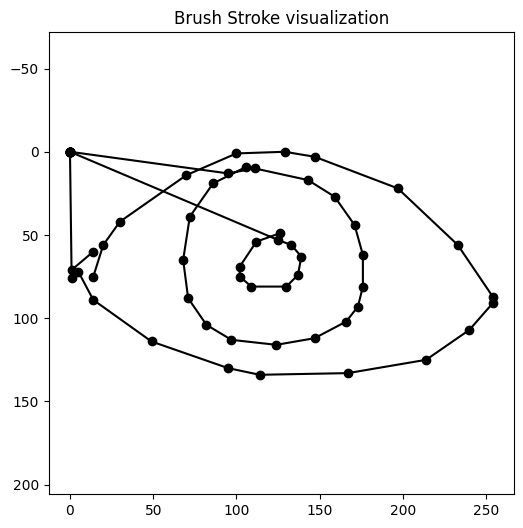

In [110]:
plt.figure(figsize=(6,6))
for stroke in eye_data1:
  x_coords, y_coords = stroke
  plt.plot(x_coords, y_coords, marker='o', c="black")

plt.gca().invert_yaxis()
plt.axis("equal")
plt.title("Brush Stroke visualization")
plt.show()

TypeError: Invalid shape (5, 2, 13) for image data

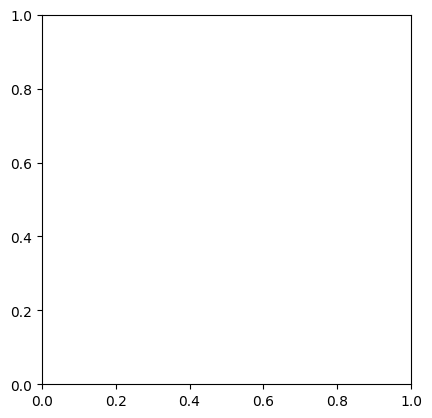

In [90]:
# # normalized data
# normalized_data = (np_data - np.min(np_data)) / (np.max(np_data) - np.min(np_data))
# normalized_data *= 225
# # print(f"Normalized data:\n{normalized_data} \nNomalized data shape: \n{normalized_data.shape}")
# plt.imshow(normalized_data, cmap="grey")
# plt.show()

In [61]:
print(np_data1)
np_data.shape, np_data.size, np_data1.shape, np_data1.size

tensor([[250., 189., 139., 100.,  83.,  61.,  43.,  26.,  11.,   3.,   2.,  11.,
          18.,  47.,  96., 148., 220., 246., 254., 255., 254., 242., 166., 148.,
         138., 134.],
        [ 59.,  40.,  31.,  28.,  30.,  37.,  47.,  64.,  91., 114., 129., 142.,
         146., 151., 152., 143., 120., 101.,  87.,  80.,  76.,  66.,  40.,  39.,
          40.,  45.],
        [104.,  99.,  89.,  79.,  80.,  89., 111., 117., 117., 102.,  75.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.],
        [ 70.,  67.,  71.,  86., 100., 111., 101.,  94.,  85.,  72.,  61.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.],
        [ 30.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.],
        [ 62.,  50.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,

(torch.Size([7, 2, 26]),
 <function Tensor.size>,
 torch.Size([14, 26]),
 <function Tensor.size>)

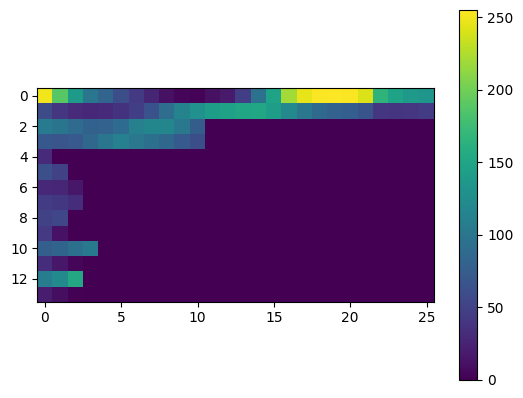

In [62]:
plt.imshow(np_data1)
plt.colorbar()
plt.show()